#### Grab information from database:

In [1]:
%matplotlib inline
import os
import django
os.chdir('/Users/lavenderca/genomics_network/')
django.setup()

In [55]:
import matplotlib.pyplot as plt
import math
import numpy
from scipy.spatial.distance import mahalanobis
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

from network import models

In [3]:
annotation = models.GeneAnnotation.objects.get(name='GRCh38_RefSeq')
datasets = models.Dataset.objects.filter(assembly__default_annotation=annotation)

genes = []
transcripts = []
for g in models.Gene.objects.filter(annotation=annotation):
    transcript = g.get_transcript_with_highest_expression()
    if transcript:
        genes.append(g)
        transcripts.append(transcript)
        
dataset_values = dict()
for dataset in datasets:
    dataset_values[dataset] = dict()
    for transcript in transcripts:
        intersection = models.TranscriptIntersection.objects.get(
            dataset=dataset,
            transcript=transcript,
        )
        dataset_values[dataset][transcript] = {
            'coding': intersection.normalized_coding_value,
            'genebody': intersection.normalized_genebody_value,
            'promoter': intersection.normalized_promoter_value,
        }

In [4]:
dataset_info = dict()
for dataset in datasets:
    experiment = models.Experiment.objects.get(dataset=dataset)
    dataset_info[dataset] = {
        'cell_type': experiment.cell_type,
        'target': experiment.target,
        'experiment_type': experiment.data_type,
    }

In [5]:
transcript_info = dict()
for transcript in transcripts:
    transcript_info[transcript] = {
        'coding_length': sum((e[1] - e[0] + 1) for e in transcript.exons),
        'median_expression': transcript.get_median_expression(),
        'variance': transcript.get_intersection_variance(),
    }

#### Shared info for plots:

In [6]:
colors = [
    '#e6194b',
    '#3cb44b',
    '#ffe119',
    '#0082c8',
    '#f58231',
    '#911eb4',
    '#46f0f0',
    '#f032e6',
    '#d2f53c',
    '#fabebe',
    '#008080',
    '#e6beff',
    '#aa6e28',
    '#fffac8',
    '#800000',
    '#aaffc3',
    '#808000',
    '#ffd8b1',
    '#000080',
    '#808080',
]

#### Perform PCA on ChIP-seq data

Use values from all transcripts.

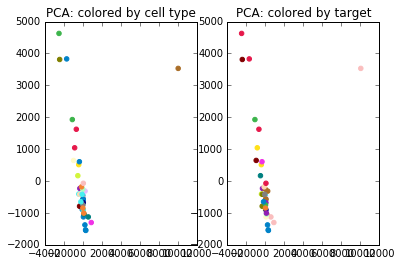

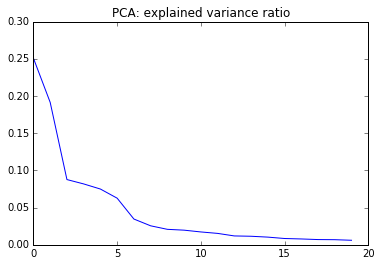

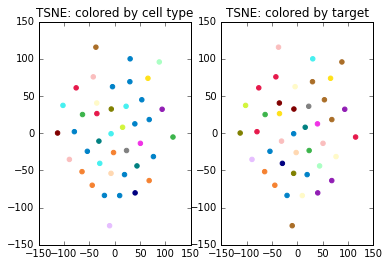

Outlier information:
36674
{'description': 'assembly:\nGRCh38\n\nbiological_replicates:\n1\n2\n\noutput_category:\nsignal\n\noutput_type:\nfold change over control\n\ntechnical_replicates:\n1_1\n2_1', 'name': 'ENCFF943TXM-ChIPseq-H3K27me3-InducedPluripotentStemCell-GRCh38', 'id': 36674, 'plus_url': None, 'ambiguous_url': 'https://www.encodeproject.org/files/ENCFF943TXM/@@download/ENCFF943TXM.bigWig', '_state': <django.db.models.base.ModelState object at 0x1134d1ef0>, 'experiment_id': 17407, 'created': datetime.datetime(2017, 5, 15, 17, 21, 28, 680804, tzinfo=<UTC>), 'slug': 'ENCFF943TXM', 'assembly_id': 2, 'minus_url': None}
{'name': 'ENCSR386RIJ-ChIPseq-H3K27me3-InducedPluripotentStemCell-Human', 'slug': '', 'created': datetime.datetime(2017, 5, 15, 17, 21, 28, 677960, tzinfo=<UTC>), 'id': 17407, '_state': <django.db.models.base.ModelState object at 0x18085f240>, 'data_type': 'ChIP-seq', 'description': 'Assay Slims:Dna binding\n\nAssay Synonyms:Chromatin immunoprecipitation sequencing

In [61]:
intersection_values = []
cell_types = []
targets = []
selected_datasets = []
for dataset in datasets:
    if dataset_info[dataset]['experiment_type'] == 'ChIP-seq':
        intersection_values.append([])
        for transcript in transcripts:
            intersection_values[-1].append(dataset_values[dataset][transcript]['genebody'])
        cell_types.append(dataset_info[dataset]['cell_type'])
        targets.append(dataset_info[dataset]['target'])
        selected_datasets.append(dataset)
            
n_components = 20
pca = PCA(n_components=n_components)
pca_out = pca.fit_transform(numpy.array(intersection_values))

cell_type_to_color = dict()
target_to_color = dict()
index = 0
for x in cell_types:
    if x not in cell_type_to_color:
        cell_type_to_color[x] = colors[index % len(colors)]
        index += 1
index = 0
for x in targets:
    if x not in target_to_color:
        target_to_color[x] = colors[index % len(colors)]
        index += 1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.scatter(
    [x[0] for x in pca_out], 
    [x[1] for x in pca_out],
    color=[cell_type_to_color[x] for x in cell_types],
)
ax1.set_title('PCA: colored by cell type')
ax2.scatter(
    [x[0] for x in pca_out], 
    [x[1] for x in pca_out],
    color=[target_to_color[x] for x in targets],
)
ax2.set_title('PCA: colored by target')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(range(n_components), pca.explained_variance_ratio_)
ax1.set_title('PCA: explained variance ratio')
plt.show()

tsne = TSNE()
tsne_out = tsne.fit_transform([x[:6] for x in pca_out])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.scatter(
    [x[0] for x in tsne_out], 
    [x[1] for x in tsne_out],
    color=[cell_type_to_color[x] for x in cell_types],
)
ax1.set_title('TSNE: colored by cell type')
ax2.scatter(
    [x[0] for x in tsne_out], 
    [x[1] for x in tsne_out],
    color=[target_to_color[x] for x in targets],
)
ax2.set_title('TSNE: colored by target')
plt.show()

outlier_index = next(i for i, x in enumerate(pca_out) if x[0] > 10000)
print('Outlier information:')
print(selected_datasets[outlier_index].pk)
print(selected_datasets[outlier_index].__dict__)
print(models.Experiment.objects.get(dataset=selected_datasets[outlier_index]).__dict__)

#### PCA on ChIP-seq data
* Filter by transcript length, variance, median expression

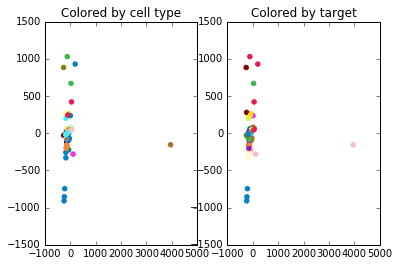

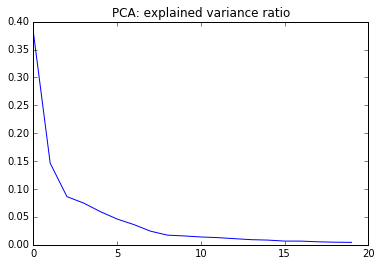

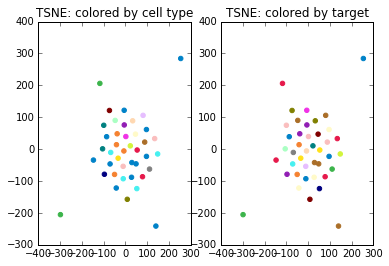

Outlier information:
{'description': 'assembly:\nGRCh38\n\nbiological_replicates:\n1\n2\n\noutput_category:\nsignal\n\noutput_type:\nfold change over control\n\ntechnical_replicates:\n1_1\n2_1', 'name': 'ENCFF943TXM-ChIPseq-H3K27me3-InducedPluripotentStemCell-GRCh38', 'id': 36674, 'plus_url': None, 'ambiguous_url': 'https://www.encodeproject.org/files/ENCFF943TXM/@@download/ENCFF943TXM.bigWig', '_state': <django.db.models.base.ModelState object at 0x1134d1ef0>, 'experiment_id': 17407, 'created': datetime.datetime(2017, 5, 15, 17, 21, 28, 680804, tzinfo=<UTC>), 'slug': 'ENCFF943TXM', 'assembly_id': 2, 'minus_url': None}
{'name': 'ENCSR386RIJ-ChIPseq-H3K27me3-InducedPluripotentStemCell-Human', 'slug': '', 'created': datetime.datetime(2017, 5, 15, 17, 21, 28, 677960, tzinfo=<UTC>), 'id': 17407, '_state': <django.db.models.base.ModelState object at 0x1787a3080>, 'data_type': 'ChIP-seq', 'description': 'Assay Slims:Dna binding\n\nAssay Synonyms:Chromatin immunoprecipitation sequencing assay

In [51]:
filtered_transcripts = []

variance_cutoffs = [
    numpy.percentile([transcript_info[x]['variance'] for x in transcripts], 50),
    numpy.percentile([transcript_info[x]['variance'] for x in transcripts], 95),
]

expression_cutoffs = [
    numpy.percentile([transcript_info[x]['median_expression'] for x in transcripts], 25),
    numpy.percentile([transcript_info[x]['median_expression'] for x in transcripts], 75),
]

for transcript in transcripts:
    info = transcript_info[transcript]
    if all([
        info['coding_length'] >= 500,
        info['variance'] >= variance_cutoffs[0],
        info['variance'] <= variance_cutoffs[1],
        info['median_expression'] >= expression_cutoffs[0],
        info['median_expression'] <= expression_cutoffs[1],
    ]):
        filtered_transcripts.append(transcript)
        
intersection_values = []
cell_types = []
targets = []
selected_datasets = []
for dataset in datasets:
    if dataset_info[dataset]['experiment_type'] == 'ChIP-seq':
        intersection_values.append([])
        for transcript in filtered_transcripts:
            intersection_values[-1].append(dataset_values[dataset][transcript]['genebody'])
        cell_types.append(dataset_info[dataset]['cell_type'])
        targets.append(dataset_info[dataset]['target'])
        selected_datasets.append(dataset)
            
n_components = 20
pca = PCA(n_components=n_components)
pca_out = pca.fit_transform(numpy.array(intersection_values))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

cell_type_to_color = dict()
target_to_color = dict()
index = 0
for x in cell_types:
    if x not in cell_type_to_color:
        cell_type_to_color[x] = colors[index % len(colors)]
        index += 1
index = 0
for x in targets:
    if x not in target_to_color:
        target_to_color[x] = colors[index % len(colors)]
        index += 1

ax1.scatter(
    [x[0] for x in pca_out], 
    [x[1] for x in pca_out],
    color=[cell_type_to_color[x] for x in cell_types],
)
ax1.set_title('Colored by cell type')
ax2.scatter(
    [x[0] for x in pca_out], 
    [x[1] for x in pca_out],
    color=[target_to_color[x] for x in targets],
)
ax2.set_title('Colored by target')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(range(n_components), pca.explained_variance_ratio_)
ax1.set_title('PCA: explained variance ratio')
plt.show()

tsne = TSNE()
tsne_out = tsne.fit_transform([x[:6] for x in pca_out])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.scatter(
    [x[0] for x in tsne_out], 
    [x[1] for x in tsne_out],
    color=[cell_type_to_color[x] for x in cell_types],
)
ax1.set_title('TSNE: colored by cell type')
ax2.scatter(
    [x[0] for x in tsne_out], 
    [x[1] for x in tsne_out],
    color=[target_to_color[x] for x in targets],
)
ax2.set_title('TSNE: colored by target')
plt.show()

outlier_index = next(i for i, x in enumerate(pca_out) if x[0] > 2000)
print('Outlier information:')
print(selected_datasets[outlier_index].__dict__)
print(models.Experiment.objects.get(dataset=selected_datasets[outlier_index]).__dict__)

#### Add transcript importance ranks based on random forest

In [45]:
intersection_values = []
cell_types = []
targets = []
for dataset in datasets:
    if dataset_info[dataset]['experiment_type'] == 'ChIP-seq':
        intersection_values.append([])
        for transcript in transcripts:
            intersection_values[-1].append(dataset_values[dataset][transcript]['genebody'])
        cell_types.append(dataset_info[dataset]['cell_type'])
        targets.append(dataset_info[dataset]['target'])
        
rf = RandomForestClassifier(n_estimators=600)

cell_type_importances = rf.fit(
    intersection_values, 
    cell_types,
).feature_importances_

target_importances = rf.fit(
    intersection_values,
    targets,
).feature_importances_

cell_type_ranks = \
    [i[0] for i in sorted(enumerate(cell_type_importances), key=lambda x: -x[1])]
target_ranks = \
    [i[0] for i in sorted(enumerate(target_importances), key=lambda x: -x[1])]
    
for transcript, ct_rank, t_rank, in zip(
        transcripts, cell_type_ranks, target_ranks):
    transcript_info[transcript].update({
            'cell_type_rank': ct_rank,
            'target_rank': t_rank,
        })

#### Select transcripts by random forest importance

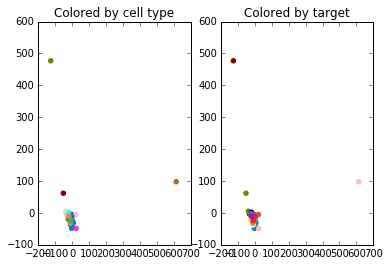

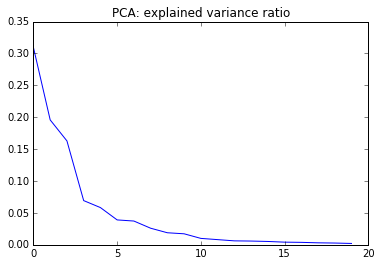

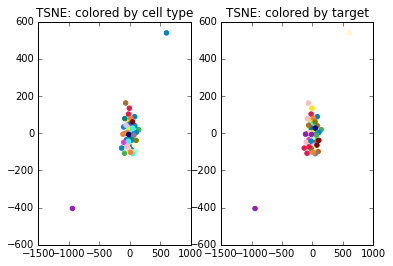

In [77]:
def rank(transcript):
    info = transcript_info[transcript]
    return info['cell_type_rank'] + info['target_rank']

filtered_transcripts = sorted(transcripts, key=lambda x: rank(x))[:100]
        
intersection_values = []
cell_types = []
targets = []
selected_datasets = []
for dataset in datasets:
    if dataset_info[dataset]['experiment_type'] == 'ChIP-seq':
        intersection_values.append([])
        for transcript in filtered_transcripts:
            intersection_values[-1].append(dataset_values[dataset][transcript]['genebody'])
        cell_types.append(dataset_info[dataset]['cell_type'])
        targets.append(dataset_info[dataset]['target'])
        selected_datasets.append(dataset)
            
n_components = 20
pca = PCA(n_components=n_components)
pca_out = pca.fit_transform(numpy.array(intersection_values))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

cell_type_to_color = dict()
target_to_color = dict()
index = 0
for x in cell_types:
    if x not in cell_type_to_color:
        cell_type_to_color[x] = colors[index % len(colors)]
        index += 1
index = 0
for x in targets:
    if x not in target_to_color:
        target_to_color[x] = colors[index % len(colors)]
        index += 1

ax1.scatter(
    [x[0] for x in pca_out], 
    [x[1] for x in pca_out],
    color=[cell_type_to_color[x] for x in cell_types],
)
ax1.set_title('Colored by cell type')
ax2.scatter(
    [x[0] for x in pca_out], 
    [x[1] for x in pca_out],
    color=[target_to_color[x] for x in targets],
)
ax2.set_title('Colored by target')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(range(n_components), pca.explained_variance_ratio_)
ax1.set_title('PCA: explained variance ratio')
plt.show()

tsne = TSNE()
tsne_out = tsne.fit_transform([x[:6] for x in pca_out])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.scatter(
    [x[0] for x in tsne_out], 
    [x[1] for x in tsne_out],
    color=[cell_type_to_color[x] for x in cell_types],
)
ax1.set_title('TSNE: colored by cell type')
ax2.scatter(
    [x[0] for x in tsne_out], 
    [x[1] for x in tsne_out],
    color=[target_to_color[x] for x in targets],
)
ax2.set_title('TSNE: colored by target')
plt.show()

#### Attempt filtering by Mahalanobis distance

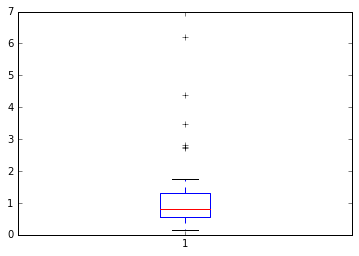

36674 6.2158429641
36754 4.37892767501
36902 3.46223801531
36874 2.83164571443
36724 2.75653272497
36672 2.72476776311
36655 1.74714840022
36653 1.52559868917
36543 1.50684230418
36570 1.3048000989
0.548399187185
1.29640965018


In [105]:
intersection_values = []
selected_datasets = []
for dataset in datasets:
    if dataset_info[dataset]['experiment_type'] == 'ChIP-seq':
        intersection_values.append([])
        for transcript in transcripts:
            intersection_values[-1].append(dataset_values[dataset][transcript]['genebody'])
        selected_datasets.append(dataset)
        
pca = PCA(n_components=3)
pca_out = pca.fit_transform(numpy.array(intersection_values))

mean = numpy.mean(pca_out, axis=0)
cov = numpy.cov(pca_out, rowvar=False)
inv = numpy.linalg.inv(cov)
m_dist = []
for vector in pca_out:
    m_dist.append(mahalanobis(vector, mean, inv))
    
plt.boxplot(m_dist)
plt.show()

for dist, ds in sorted(zip(m_dist, selected_datasets), key=lambda x: -x[0])[:10]:
    print(ds.pk, dist)
    
print(numpy.percentile(m_dist, 25))
print(numpy.percentile(m_dist, 75))

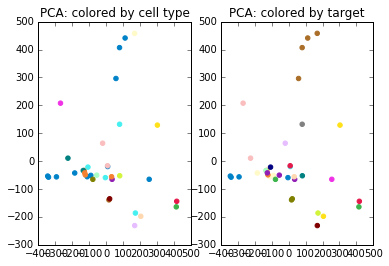

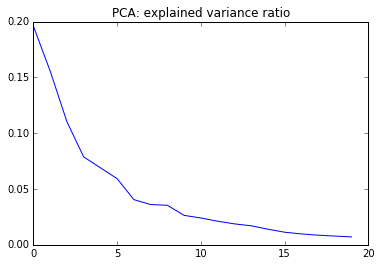

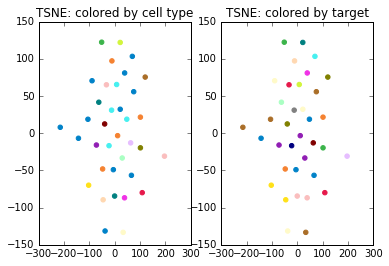

In [136]:
def rank(transcript):
    info = transcript_info[transcript]
    return info['cell_type_rank'] + info['target_rank']

filtered_transcripts = sorted(transcripts, key=lambda x: rank(x))[:1000]

intersection_values = []
selected_datasets = []
for dataset in datasets:
    if dataset_info[dataset]['experiment_type'] == 'ChIP-seq':
        intersection_values.append([])
        for transcript in filtered_transcripts:
            intersection_values[-1].append(dataset_values[dataset][transcript]['genebody'])
        selected_datasets.append(dataset)
        
pca = PCA(n_components=3)
pca_out = pca.fit_transform(numpy.array(intersection_values))

mean = numpy.mean(pca_out, axis=0)
cov = numpy.cov(pca_out, rowvar=False)
inv = numpy.linalg.inv(cov)
m_dist = []
for vector in pca_out:
    m_dist.append(mahalanobis(vector, mean, inv))
    
Q1 = numpy.percentile(m_dist, 25)
Q3 = numpy.percentile(m_dist, 75)
cutoff = Q3 + 1.5 * (Q3 - Q1)

_datasets = []
for dist, ds in zip(m_dist, selected_datasets):
    if dist < cutoff:
        _datasets.append(ds)
selected_datasets = _datasets

intersection_values = []
cell_types = []
targets = []
for dataset in selected_datasets:
    intersection_values.append([])
    for transcript in filtered_transcripts:
        intersection_values[-1].append(dataset_values[dataset][transcript]['genebody'])
    cell_types.append(dataset_info[dataset]['cell_type'])
    targets.append(dataset_info[dataset]['target'])
        
n_components = 20
pca = PCA(n_components=n_components)
pca_out = pca.fit_transform(numpy.array(intersection_values))

cell_type_to_color = dict()
target_to_color = dict()
index = 0
for x in cell_types:
    if x not in cell_type_to_color:
        cell_type_to_color[x] = colors[index % len(colors)]
        index += 1
index = 0
for x in targets:
    if x not in target_to_color:
        target_to_color[x] = colors[index % len(colors)]
        index += 1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.scatter(
    [x[0] for x in pca_out], 
    [x[1] for x in pca_out],
    color=[cell_type_to_color[x] for x in cell_types],
)
ax1.set_title('PCA: colored by cell type')
ax2.scatter(
    [x[0] for x in pca_out], 
    [x[1] for x in pca_out],
    color=[target_to_color[x] for x in targets],
)
ax2.set_title('PCA: colored by target')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(range(n_components), pca.explained_variance_ratio_)
ax1.set_title('PCA: explained variance ratio')
plt.show()

tsne = TSNE()
tsne_out = tsne.fit_transform([x[:6] for x in pca_out])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.scatter(
    [x[0] for x in tsne_out], 
    [x[1] for x in tsne_out],
    color=[cell_type_to_color[x] for x in cell_types],
)
ax1.set_title('TSNE: colored by cell type')
ax2.scatter(
    [x[0] for x in tsne_out], 
    [x[1] for x in tsne_out],
    color=[target_to_color[x] for x in targets],
)
ax2.set_title('TSNE: colored by target')
plt.show()

In [ ]:
intersection_values = []
cell_types = []
targets = []
selected_datasets = []
for dataset in datasets:
    if dataset_info[dataset]['experiment_type'] == 'ChIP-seq':
        intersection_values.append([])
        for transcript in filtered_transcripts:
            intersection_values[-1].append(dataset_values[dataset][transcript]['genebody'])
        cell_types.append(dataset_info[dataset]['cell_type'])
        targets.append(dataset_info[dataset]['target'])
        selected_datasets.append(dataset)
        
rf = RandomForestClassifier(n_estimators=600)

cell_type_importances = rf.fit(
    intersection_values, 
    cell_types,
).feature_importances_

target_importances = rf.fit(
    intersection_values,
    targets,
).feature_importances_

cell_type_ranks = \
    [i[0] for i in sorted(enumerate(cell_type_importances), key=lambda x: -x[1])]
target_ranks = \
    [i[0] for i in sorted(enumerate(target_importances), key=lambda x: -x[1])]
    
for transcript, ct_rank, t_rank, in zip(
        transcripts, cell_type_ranks, target_ranks):
    transcript_info[transcript].update({
            'cell_type_rank': ct_rank,
            'target_rank': t_rank,
        })

In [ ]:
filtered_transcripts = []

def filter_function(x):
    return (
        transcript_info[x]['cell_type_rank'] \
        + transcript_info[x]['target_rank']
    )

for transcript in sorted(
        transcripts, 
        key=lambda x: filter_function(x))[:5000]:
    filtered_transcripts.append(transcript)

In [ ]:
intersection_values = []
for dataset in datasets:
    if dataset_info[dataset]['experiment_type'] == 'ChIP-seq':
        intersection_values.append([])
        for transcript in filtered_transcripts:
            intersection_values[-1].append(dataset_values[dataset][transcript]['genebody'])
        
pca = PCA(n_components=5)
pca_out = pca.fit_transform(numpy.array(intersection_values))

plt.plot(range(5), pca.explained_variance_ratio_)
plt.show()

In [ ]:
tsne = TSNE()
out = tsne.fit_transform(pca_out)

x_values = [value[0] for value in out]
y_values = [value[1] for value in out]

plt.scatter(x_values, y_values)
plt.show()

In [ ]:
dataset_values = dict()
for dataset in datasets:
    dataset_values[dataset] = dict()
    for transcript in gene_to_transcript.values():
        dataset_values[dataset][transcript] = \
            models.TranscriptIntersection.objects.get(
                dataset=dataset,
                transcript=transcript,
            ).normalized_coding_value

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(n_estimators=2000, oob_score=True)

transcripts = gene_to_transcript.values()
intersection_values = []
for dataset in datasets:
    intersection_values.append([])
    for transcript in transcripts:
        intersection_values[-1].append(dataset_values[dataset][transcript])

cell_types = []
for dataset in datasets:
    cell_types.append(
        models.Experiment.objects.get(dataset=dataset).cell_type)

# rf.fit(intersection_values, cell_types)
# rf.oob_score_
oob_errors = []
for n in [10 * (n + 1) for n in range(100)]:
    rf = RandomForestClassifier(n_estimators=n, oob_score=True)
    rf.fit(intersection_values, cell_types)
    oob_errors.append([n, (1 - rf.oob_score_)])

plt.plot([x[0] for x in oob_errors], [x[1] for x in oob_errors])
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(n_estimators=2000, oob_score=True)

transcripts = gene_to_transcript.values()
intersection_values = []
for dataset in datasets:
    intersection_values.append([])
    for transcript in transcripts:
        intersection_values[-1].append(dataset_values[dataset][transcript])

targets = []
for dataset in datasets:
    targets.append(
        models.Experiment.objects.get(dataset=dataset).target)

# rf.fit(intersection_values, cell_types)
# rf.oob_score_
oob_errors = []
for n in [10 * (n + 1) for n in range(100)]:
    rf = RandomForestClassifier(n_estimators=n, oob_score=True)
    rf.fit(intersection_values, targets)
    oob_errors.append([n, (1 - rf.oob_score_)])

plt.plot([x[0] for x in oob_errors], [x[1] for x in oob_errors])
plt.show()

In [ ]:
transcripts = gene_to_transcript.values()
intersection_values = []
for dataset in datasets:
    intersection_values.append([])
    for transcript in transcripts:
        intersection_values[-1].append(dataset_values[dataset][transcript])
        
cell_types = []
for dataset in datasets:
    cell_types.append(
        models.Experiment.objects.get(dataset=dataset).cell_type)

targets = []
for dataset in datasets:
    targets.append(
        models.Experiment.objects.get(dataset=dataset).target)
    
experiment_types = []
for dataset in datasets:
    experiment_types.append(
        models.Experiment.objects.get(dataset=dataset).data_type)
    
rf = RandomForestClassifier(n_estimators=600)

rf.fit(intersection_values, cell_types)
cell_type_importances = rf.feature_importances_ 
rf.fit(intersection_values, targets)
target_importances = rf.feature_importances_
rf.fit(intersection_values, experiment_types)
experiment_type_importances = rf.feature_importances_

In [ ]:
plt.scatter(cell_type_importances, experiment_type_importances)
plt.xlim(xmin=-0.001, xmax=0.003)
plt.ylim(ymin=-0.001, ymax=0.003)
plt.show()

In [ ]:
cell_type_ranks = \
    [i[0] for i in sorted(enumerate(cell_type_importances), key=lambda x: -x[1])]
target_ranks = \
    [i[0] for i in sorted(enumerate(target_importances), key=lambda x: -x[1])]
total_ranks = [x + y for x, y in zip(cell_type_ranks, target_ranks)]

transcript_ranks = dict()
for transcript, rank in zip(transcripts, total_ranks):
    transcript_ranks[transcript] = rank
    
filtered_transcripts = \
    [x[0] for x in sorted(transcript_ranks.items(), key=lambda x: -x[1])][100:400]

In [ ]:
intersection_values = []
for dataset in datasets:
    intersection_values.append([])
    for transcript in filtered_transcripts:
        intersection_values[-1].append(dataset_values[dataset][transcript])
        
pca = PCA(n_components=20)
pca_out = pca.fit_transform(numpy.array(intersection_values))
print(pca.explained_variance_ratio_)

In [ ]:
x_values = [value[2] for value in pca_out]
y_values = [value[3] for value in pca_out]

plt.scatter(x_values, y_values)
plt.show()

In [ ]:
from sklearn.manifold import TSNE

filtered_transcripts = \
    [x[0] for x in sorted(transcript_ranks.items(), key=lambda x: -x[1])][:50]
    
intersection_values = []
for dataset in datasets:
    intersection_values.append([])
    for transcript in filtered_transcripts:
        intersection_values[-1].append(dataset_values[dataset][transcript])

pca = TruncatedSVD(n_components=2)
pca_out = pca.fit_transform(numpy.array(intersection_values))
        
tsne = TSNE()
out = tsne.fit_transform(pca_out)

type_to_color = dict()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
index = 0
for x in cell_types:
    if x not in type_to_color:
        type_to_color[x] = colors[index % len(colors)]
        index += 1

plt.scatter(
    [x[0] for x in pca_out], 
    [x[1] for x in pca_out], 
    color=[type_to_color[x] for x in cell_types],
)
plt.xlim(xmin=-2000, xmax=2000)
plt.ylim(ymin=-2000, ymax=2000)
plt.show()

In [ ]:
transcript_coding_lengths = dict()
for transcript in gene_to_transcript.values():
    transcript_coding_lengths[transcript] = \
        sum((e[1] - e[0] + 1) for e in transcript.exons)

In [ ]:
models.Gene.objects.get(transcript=filtered_transcripts[1]).name

In [ ]:
median_expression_values = dict()
for transcript in gene_to_transcript.values():
    median_expression_values[transcript] = transcript.get_median_expression()

In [ ]:
variance_values = dict()
for transcript in gene_to_transcript.values():
    variance_values[transcript] = transcript.get_intersection_variance()

In [ ]:
gene_info = dict()
for gene, transcript in gene_to_transcript.items():
    gene_info[gene] = {
        'transcript': transcript,
        'median_expression': median_expression_values[transcript],
        'coding_length': transcript_coding_lengths[transcript],
        'variance': variance_values[transcript],
    }

In [ ]:
def plot_info(info_dict):
    length_histogram = numpy.histogram(
        [x['coding_length'] for x in info_dict.values()],
        bins=[50 * i for i in range(200)],
    )
    expression_histogram = numpy.histogram(
        [x['median_expression'] for x in info_dict.values()],
        bins=[0.5 * i for i in range(40)],
    )
    variance_histogram = numpy.histogram(
        [x['variance'] for x in info_dict.values()],
        bins=[0.5 * i for i in range(40)],
    )
    
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2)
    
    ax1.bar(length_histogram[1][1:], length_histogram[0], width=50)
    ax1.set_xlim([0, 4000])
    
    ax2.bar(expression_histogram[1][1:], expression_histogram[0], width=0.5)
    ax2.set_xlim([0, 20])
    
    ax3.bar(variance_histogram[1][1:], variance_histogram[0])
    
    ax4.scatter(
        [math.log(x['variance'] + 1) for x in info_dict.values()], 
        [x['median_expression'] for x in info_dict.values()],
    )
    
    plt.show()

In [ ]:
variance_cutoffs = [
    numpy.percentile([x['variance'] for x in gene_info.values()], 50),
    numpy.percentile([x['variance'] for x in gene_info.values()], 75),
]

expression_cutoffs = [
    numpy.percentile([x['median_expression'] for x in gene_info.values()], 25),
    numpy.percentile([x['median_expression'] for x in gene_info.values()], 50),
]

filtered_genes = dict()
for gene, _dict in gene_info.items():
    if all([
        _dict['coding_length'] >= 500,
        _dict['variance'] >= variance_cutoffs[0],
        _dict['variance'] <= variance_cutoffs[1],
        _dict['median_expression'] >= expression_cutoffs[0],
        _dict['median_expression'] <= expression_cutoffs[1],
    ]):
        filtered_genes[gene] = _dict

In [ ]:
print(len(genes))
plot_info(gene_info)

In [ ]:
print(len(filtered_genes))
plot_info(filtered_genes)

In [ ]:
intersection_matrix = []
transcripts = [x['transcript'] for x in filtered_genes.values()]
for dataset in datasets:
    intersections = []
    for transcript in transcripts:
        intersections.append(
            models.TranscriptIntersection.objects.get(
                dataset=dataset,
                transcript=transcript,
            ).normalized_coding_value
        )
    intersection_matrix.append(intersections)

In [ ]:
pca = PCA(n_components=20)
pca_out = pca.fit_transform(numpy.array(intersection_matrix))
print(pca.explained_variance_ratio_)

In [ ]:
plt.scatter(range(20), pca.explained_variance_ratio_)
plt.show

In [ ]:
x_values = [value[0] for value in pca_out]
y_values = [value[1] for value in pca_out]

plt.scatter(x_values, y_values)
plt.show()